# 📚 Librerías y Dependencias del Proyecto

Este libro de Python aborda la temática de **Análisis y Simulación de Sistemas Dinámicos**. Específicamente, se simula la dinámica lineal de un sistema de dos tanques acoplados, su linealización y la comparación de las 2 dinámicas.

| Librería | Propósito en el Proyecto | Conceptos Clave |
| :--- | :--- | :--- |
| **`numpy`** | Base para cálculos numéricos vectorizados. Utilizada en la definición de matrices de sistema linealizado y manipulación de datos de simulación. | **Álgebra Lineal**, Arreglos multidimensionales. |
| **`scipy.integrate.solve_ivp`** | Herramienta esencial para la simulación de la **dinámica no lineal** del sistema. Resuelve el conjunto de Ecuaciones Diferenciales Ordinarias (EDOs). | **EDO no lineal:** $\frac{d\mathbf{h}}{dt} = \mathbf{f}(\mathbf{h}, u)$. |
| **`scipy.interpolate.interp1d`** | Usada para crear una función continua de la señal de entrada (PBRS) que puede ser evaluada por el integrador numérico en cualquier instante de tiempo. | **Interpolación lineal** de la señal de estímulo. |
| **`matplotlib.pyplot`** | Generación de visualizaciones para comparar las respuestas temporales del modelo **no lineal** y el modelo **linealizado**. | Gráficos de series de tiempo. |

### Contexto de Simulación

El sistema dinámico no lineal se describe mediante EDOs. Para la linealización, se utiliza el punto de operación $(\mathbf{h}_0, u_0)$.

El modelo linealizado resultante tendrá la forma de un sistema en espacio de estados:

$$
\Delta\dot{\mathbf{h}} = \mathbf{A}\Delta\mathbf{h} + \mathbf{B}\Delta u
$$

Donde $\mathbf{A}$ es el Jacobiano del sistema evaluado en el punto de operación.

In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# ⚙️ Parámetros Físicos y de Simulación

Este bloque define las constantes físicas del sistema de tanques acoplados y los parámetros de la discretización temporal utilizados para la simulación numérica.

### Parámetros Físicos del Sistema (SI)

Los modelos dinámicos se basan en la ecuación de Bernoulli y la ley de Torricelli para describir el flujo de agua entre los tanques.

| Variable | Unidad de medida | Descripción |
| :--- | :----- | :--- |
| **A** | $\text{m}^2$ | Área transversal de los tanques (asumidos idénticos). |
| **a1** | $\text{m}^2$ | Área del orificio de salida del Tanque 1. |
| **a2** | $\text{m}^2$ | Área del orificio de salida del Tanque 2. |
| **g** | $\text{m}/\text{s}^2$ | Constante de la aceleración de la gravedad. |
| **eta** | $\text{m}^3/(\text{s}\cdot\text{V})$ | Constante de caudal volumétrico de la bomba. |

La dinámica de la altura $h_i$ se rige por el balance de masas, donde la variación de volumen es proporcional al flujo neto:

$$
A \frac{dh_i}{dt} = Q_{in, i} - Q_{out, i}
$$

El flujo de salida por orificio sigue la ley de Torricelli: $Q_{out} = a \sqrt{2g h}$.

### Parámetros de Simulación y Ruido

| Variable | Unidad de medida | Descripción |
| :--- | :--- | :--- |
| **dt** | $\text{s}$ | Intervalo de muestreo ($T_s$) para la simulación numérica. |
| **T\_sim** | $\text{s}$ | Duración total de la simulación del sistema. |
| **h0** | $\text{m}$ | Estado inicial del sistema: $\mathbf{h}(0)$. |
| **noise\_input\_std** | $\text{V}$ | Desviación estándar ($\sigma$) del ruido Gaussiano agregado a la entrada de control $u(t)$. |
| **noise\_output\_std** | $\text{m}$ | Desviación estándar ($\sigma$) del ruido Gaussiano agregado a las alturas medidas $h_i(t)$. |
| **t_cambio** | $\text{s}$ | Intervalo de tiempo para el cambio de voltaje a la entrada de control $u(t)$ |
| **V_min** | $\text{V}$ | Valor mínimo posible de la entrada de control $u(t)$ |
| **V_max** | $\text{V}$ | Valor máximo posible de la entrada de control $u(t)$ |

In [3]:
# Parámetros físicos del sistema en unidades SI
A = 28e-4
a1 = 0.071e-4
a2 = a1
g = 9.81
eta = 0.5e-5

# Tiempo de simulación y condiciones iniciales
dt = 0.05
T_sim = 600
t = np.arange(0, T_sim + dt, dt)  # Vector de tiempo discreto
n = len(t)                        # Número total de puntos muestreados
h0 = np.array([0.0, 0.0])         # Alturas iniciales de los tanques [m]

# Ruido y parámetros de la Señal
noise_input_std = 0
noise_output_std = 0
t_cambio = 20
V_min = 0
V_max = 2.0

# 🌊 Modelo Dinámico No Lineal del Sistema de Tanques

La función `nonlinear_ode_system_model` implementa el conjunto de **Ecuaciones Diferenciales Ordinarias (EDOs)** que describen la dinámica de las alturas de los tanques ($\mathbf{h} = [h_1, h_2]^T$) basándose en el balance de masa.

### Ecuaciones Fundamentales

El modelo se basa en la Ley de Torricelli, que establece que la velocidad de salida de un fluido por un orificio es proporcional a la raíz cuadrada de la altura.

La formulación general para el tanque $i$ es:
$$
A \frac{dh_i}{dt} = Q_{in, i} - Q_{out, i}
$$

### 1. Dinámica del Tanque 1 ($h_1$)

$$
\frac{dh_1}{dt} = \frac{\eta}{A} u - \frac{a_1}{A} \sqrt{2g h_1}
$$

### 2. Dinámica del Tanque 2 ($h_2$)

$$
\frac{dh_2}{dt} = \frac{a_1}{A} \sqrt{2g h_1} - \frac{a_2}{A} \sqrt{2g h_2}
$$

| Símbolo | Concepto Físico |
| :--- | :--- |
| $\frac{dh}{dt}$ | Tasa de cambio de la altura (derivada). |
| $\frac{\eta}{A} u$ | Término de caudal de entrada por la bomba. |
| $\frac{a_i}{A} \sqrt{2g h_i}$ | Término de caudal de salida por el orificio $i$. |


In [4]:
def nonlinear_ode_system_model(t, h, u_func, A, a1, a2, g, eta):
    # Desempaquetado del vector de estados (niveles h1 y h2)
    h1, h2 = h

    # Asegurar que las alturas sean no negativas para el cálculo de la raíz cuadrada
    h1_seguro = np.maximum(h1, 0)
    h2_seguro = np.maximum(h2, 0)

    # Obtener el valor de la entrada de control (voltaje) en el tiempo t
    u = u_func(t)

    # Ecuación diferencial Tanque 1 (dh1/dt): Entrada de bomba - Salida a Tanque 2
    # El flujo de salida es Q_out = a * sqrt(2 * g * h).
    dh1dt = -(a1 / A) * np.sqrt(2 * g * h1_seguro) + (eta * u) / A

    # Ecuación diferencial Tanque 2 (dh2/dt): Entrada de Tanque 1 - Salida al ambiente
    dh2dt = (a1 / A) * np.sqrt(2 * g * h1_seguro) - (a2 / A) * np.sqrt(2 * g * h2_seguro)

    # Vector de derivadas de estado
    return [dh1dt, dh2dt]

# 📉 Configuración de la Señal de Estímulo PBRS

Para la identificación del sistema linealizado, se utiliza una señal binaria pseudoaleatoria (**PBRS** - *Pseudo-Random Binary Signal*) de múltiples niveles.

### 1. Reproducibilidad

Se utiliza un generador de números pseudoaleatorios explícito con una semilla (`seed_stream`) fija para asegurar que los resultados sean **determinísticos y reproducibles** para la generación de ruido en la entrada y la salida.

* **Generador:** `np.random.Generator` con el algoritmo `np.random.MT19937`.

### 2. Puntos de Transición

La señal PBRS se define por el tiempo que permanece en cada valor (*dwell time*), descrito como una relación:

$$
\text{Índice}_{\text{cambio}} = \frac{t_{\text{cambio}}}{dt}
$$

Que indica cuántas muestras deben transcurrir entre cada cambio de valor en la señal.

### 3. Valores de Amplitud

Los valores de los escalones de voltaje (`valores_escalones`) de la señal PBRS se han quemado para garantizar la reproducibilidad de la señal de entrada en cualquier ejecución.

In [5]:
# Ajuste de parámetros de aleatoriedad
seed_stream = 100
rng_stream = np.random.Generator(np.random.MT19937(seed_stream))

# Generación de incides de cambio de la señal PBRS
t_cambio_indices = np.arange(0, n, int(t_cambio / dt))

# Arreglo fijo de los valores de voltaje (magnitud) que toma cada escalón de la señal PBRS
valores_escalones = np.array([
    1.086809883581931, 0.556738770187592, 0.849035181498266, 1.689552264639807,
    0.009437712381945, 0.243138241566228, 1.341498169453557, 1.651705510210095,
    0.273413179369906, 1.150186658854500, 1.782643908624528, 0.418404244234379,
    0.370656439100150, 0.216753780928510, 0.439394985249984, 1.957247569414739,
    1.623366298178647, 0.343882025465188, 1.632449497451680, 0.548147494083398,
    0.863408367326243, 1.880059639244749, 1.635298757553455, 0.672223900241797,
    0.350820907484673, 0.745664092579846, 0.011377014705147, 0.504852706889681,
    1.591325016946575, 0.030509942492678, 1.197686753856986, 1.207609078085707,
    0.210295370824113, 0.763886889886220, 0.072952113185138, 1.780823126884151,
    1.961841714024623, 0.119883977636075, 1.781091889457008, 1.153802998800066,
    1.484959378195955
])

# 📈 Generación de la Señal PBRS Multivalor

Este bloque de código construye la señal de entrada **ideal** para la bomba ($u(t)$) utilizando los tiempos de cambio (`t_cambio_indices`) y las amplitudes predefinidas (`valores_escalones`).

La señal ideal $u_{\text{ideal}}[k]$ puede describirse matemáticamente de la siguiente manera:

$$
u_{\text{ideal}}[k] = \text{Valor}_i, \quad \text{para } t_{\text{cambio}, i} \le k \cdot dt < t_{\text{cambio}, i+1}
$$

Donde $t_{\text{cambio}, i}$ son los tiempos correspondientes a los `t_cambio_indices`.

### Adición de ruido gaussiano

El ruido de entrada simula perturbaciones o inexactitudes en la señal de control. Se modela como ruido blanco gaussiano y se utiliza el generador `rng_stream` para producir una distribución **normal estándar** $\left( \mu=0, \sigma=1 \right)$, que luego se escala por la desviación estándar del ruido de entrada (`noise_input_std`).

$$
u_{\text{ruidosa}}[k] = u_{\text{ideal}}[k] + \sigma_{\text{input}} \cdot w[k]
$$
Donde $w[k]$ es una muestra de la distribución normal estándar y $\sigma_{\text{input}}$ es `noise_input_std`.

### Saturación (*Clamping*)

La bomba física tiene límites operativos de voltaje. El código aplica la función `np.clip` para simular esta **saturación**, asegurando que el voltaje ruidoso permanezca dentro del rango físicamente posible:

$$
u_{\text{ruidosa}}[k] =
\begin{cases}
V_{\text{max}} & \text{si } u_{\text{ruidosa}}[k] > V_{\text{max}} \\
u_{\text{ruidosa}}[k] & \text{si } V_{\text{min}} \le u_{\text{ruidosa}}[k] \le V_{\text{max}} \\
V_{\text{min}} & \text{si } u_{\text{ruidosa}}[k] < V_{\text{min}}
\end{cases}
$$

In [6]:
# Inicialización del vector de la señal de entrada ideal (voltaje de la bomba)
u_ideal = np.zeros_like(t)

# Iterar sobre los índices de tiempo donde la señal PBRS cambia de valor
for i in range(len(t_cambio_indices)):
    idx_start = t_cambio_indices[i]

    if i == len(t_cambio_indices) - 1:
        idx_end = n
    else:
        idx_end = t_cambio_indices[i+1]

    u_ideal[idx_start:idx_end] = valores_escalones[i]

# Generación del vector de ruido Gaussiano (normal)
ruido_input = noise_input_std * rng_stream.standard_normal(size=t.shape)

# Creación de señal de entrada ruidosa y clamping
u_ruidosa = u_ideal + ruido_input
u_ruidosa = np.clip(u_ruidosa, V_min, V_max)

# 💻 Simulación del Comportamiento No Lineal

Este bloque ejecuta la simulación de la dinámica no lineal del sistema de tanques utilizando el integrador numérico **`scipy.integrate.solve_ivp`**.

### Función de Interpolación de Entrada

La función de entrada $\mathbf{u}(t)$ es una secuencia de escalones discretos. El integrador (`solve_ivp`) requiere una entrada continua o que pueda ser evaluada en cualquier punto intermedio dentro de sus pasos de tiempo adaptativos.

* **`interp1d`:** Crea una función continua (`u_fun`) a partir de los datos discretos $(t, u_{\text{ruidosa}})$.
* **Tipo (`kind='linear'`):** Utiliza interpolación lineal entre los puntos de muestreo.

### Integrador Numérico (`solve_ivp`)

La solución de un sistema de EDOs se logra mediante la integración numérica:

$$
\frac{d\mathbf{h}}{dt} = \mathbf{f}(\mathbf{h}, u(t))
$$

| Parámetro | Valor | Propósito |
| :--- | :--- | :--- |
| **`fun`** | `ode_wrapper` | Función $\mathbf{f}(t, \mathbf{h})$ que retorna las derivadas. |
| **`t_span`** | $[t_0, t_{end}]$ | Límite temporal de la integración. |
| **`y0`** | $\mathbf{h}_0$ | Vector de condiciones iniciales. |
| **`method`** | `'RK45'` | Algoritmo **Runge-Kutta** de orden 4 y 5. Un método adaptativo robusto. |
| **`t_eval`** | $t$ | Especifica que la solución debe ser evaluada y reportada en los puntos del vector de tiempo discreto $t$. |
| **`rtol`, `atol`** | $10^{-6}, 10^{-8}$ | **Tolerancias** para controlar el error local de la integración (adaptativo). |

### Resultado de la Simulación

La estructura de la solución (`sol`) se procesa para facilitar el acceso a los datos.

In [7]:
# Función de interpolación
u_fun = interp1d(t, u_ruidosa, kind='linear', fill_value='extrapolate')

# Función ODE que encapsula el modelo no lineal y sus parámetros
ode_wrapper = lambda tt, hh: nonlinear_ode_system_model(tt, hh, u_fun, A, a1, a2, g, eta)

# Ejecución de la integración numérica del sistema no lineal (Simulación)
sol = solve_ivp(
    fun=ode_wrapper,
    t_span=[t[0], t[-1]],
    y0=h0,
    method='RK45',
    t_eval=t,
    rtol=1e-6,
    atol=1e-8
)

# Transposición del resultado: sol.y pasa de (n_estados x n_puntos) a (n_puntos x n_estados)
h_out = sol.y.T
h1_sim = h_out[:, 0] # Altura simulada del Tanque 1
h2_sim = h_out[:, 1] # Altura simulada del Tanque 2
t_out = sol.t        # Vector de tiempo de la solución

# 📉 Modelado de la Medición de Salida (Ruido)

Para simular la adquisición de datos en un sistema real, se añade **ruido de medición Gaussiano** a las alturas simuladas, $\mathbf{h}_{\text{sim}} = [h_{1, \text{sim}}, h_{2, \text{sim}}]^T$.

### Generación de Ruido de Medición

El ruido de salida simula la incertidumbre asociada a los sensores de nivel (e.g., errores de resolución, fluctuaciones).

* **Distribución:** Ruido blanco gaussiano, escalado por la desviación estándar de la salida (`noise_output_std`).
$$
h_{i, \text{ruidosa}}[k] = h_{i, \text{sim}}[k] + \sigma_{\text{output}} \cdot w_i[k]
$$
Donde $w_i[k]$ es una muestra normal estándar y $\sigma_{\text{output}}$ es `noise_output_std`.

### Aplicación de Restricción Física (Límite Inferior)

Físicamente, la altura del agua en un tanque nunca puede ser negativa. Por lo tanto, se impone una condición para garantizar que no ocurra esa anomalía.

$$
h_{i, \text{ruidosa}}[k] = \max(h_{i, \text{sim}}[k] + \text{ruido}_i[k], 0.0)
$$

In [8]:
# Generación de ruido Gaussiano para la salida del Tanque 1 (h1_sim).
ruido_h1 = noise_output_std * rng_stream.standard_normal(size=h1_sim.shape)

# Generación de ruido Gaussiano para la salida del Tanque 2 (h2_sim).
ruido_h2 = noise_output_std * rng_stream.standard_normal(size=h2_sim.shape)

# Alturas ruidosas
h1_ruidosa = np.maximum(h1_sim + ruido_h1, V_min)
h2_ruidosa = np.maximum(h2_sim + ruido_h2, V_min)

In [9]:
# Datos de simulación finales
t_full = t_out
u_full = u_ruidosa
h1_full = h1_ruidosa
h2_full = h2_ruidosa

N_TOTAL = t_full.shape[0]

# 📊 Visualización de la Simulación del Sistema No Lineal

Este script genera un conjunto de tres gráficas para visualizar la señal de entrada ruidosa** y las alturas simuladas de los tanques ($h_1$ y $h_2$), incluyendo el ruido de medición. El objetivo es tener una visión clara del comportamiento dinámico del sistema bajo la excitación de la señal PBRS.

Es importante señalar que se multiplica por 100 las salidas para convertirlas a centímetros.

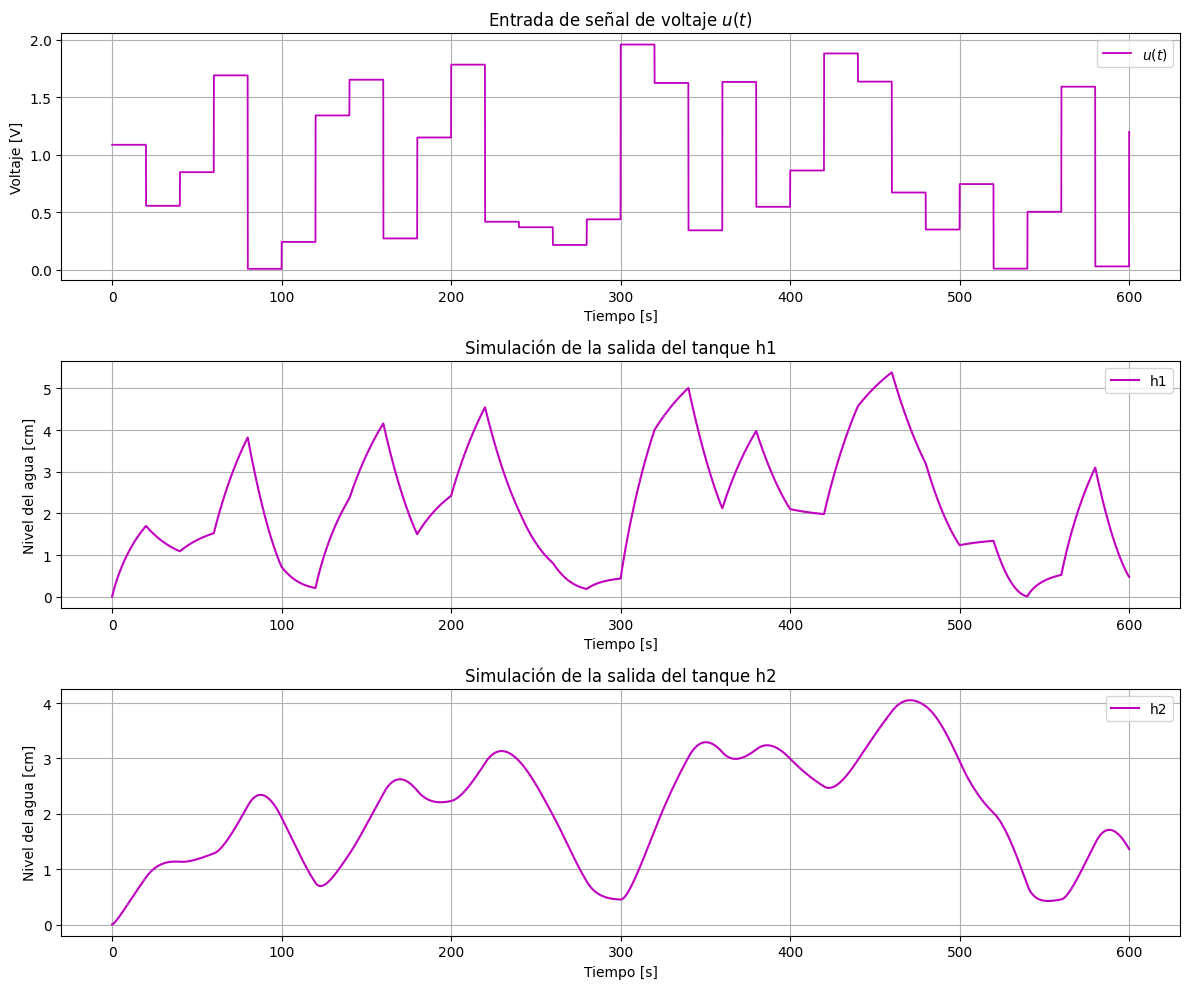

In [10]:
# Figura para visualizar las señales de entrada y salida del sistema.
plt.figure(figsize=(12, 10))

# Subgráfica 1: Señal de entrada de control (voltaje de la bomba).
plt.subplot(3, 1, 1)
plt.plot(t_full, u_full, 'm', linewidth=1.3, label='$u(t)$')
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')
plt.title(f'Entrada de señal de voltaje $u(t)$')
plt.legend()
plt.grid(True)

# Subgráfica 2: Nivel del agua del Tanque 1.
plt.subplot(3, 1, 2)
plt.plot(t_full, h1_full * 100, 'm', linewidth=1.5, label='h1') # (Convertido a cm)
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title('Simulación de la salida del tanque h1')
plt.legend()
plt.grid(True)

# Subgráfica 3: Nivel del agua del Tanque 2.
plt.subplot(3, 1, 3) # Tercera posición.
plt.plot(t_full, h2_full * 100, 'm', linewidth=1.5, label='h2') # (convertido a cm).
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title('Simulación de la salida del tanque h2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 📐 Linealización y Matrices de Espacio de Estados

El modelo no lineal $\dot{\mathbf{h}} = \mathbf{f}(\mathbf{h}, u)$ se linealiza alrededor de un punto de operación de equilibrio $(\mathbf{h}_{op}, u_{op})$ para obtener el modelo lineal de espacio de estados:

$$
\Delta\dot{\mathbf{h}} = \mathbf{A}\Delta\mathbf{h} + \mathbf{B}\Delta u
$$

Donde $\Delta\mathbf{h} = \mathbf{h} - \mathbf{h}_{op}$ y $\Delta u = u - u_{op}$.

## 1. Matriz de Estado $\mathbf{A}$ (Jacobiano con respecto al Estado)

La matriz $\mathbf{A}$ es la matriz Jacobiana del vector de funciones de estado $\mathbf{f}$ con respecto al vector de estados $\mathbf{h} = [h_1, h_2]^T$, evaluada en el punto de operación:

$$
\mathbf{A} = \left. \frac{\partial \mathbf{f}}{\partial \mathbf{h}} \right|_{(\mathbf{h}_{op}, u_{op})} =
\begin{bmatrix}
\frac{\partial f_1}{\partial h_1} & \frac{\partial f_1}{\partial h_2} \\
\frac{\partial f_2}{\partial h_1} & \frac{\partial f_2}{\partial h_2}
\end{bmatrix}_{(\mathbf{h}_{op}, u_{op})}
$$

| Elemento | Derivada | Cálculo |
| :--- | :--- | :--- |
| $\mathbf{A}_{11}$ | $\frac{\partial f_1}{\partial h_1}$ | $- \frac{a_1}{A} \sqrt{\frac{g}{2h_{1}}}$ |
| $\mathbf{A}_{12}$ | $\frac{\partial f_1}{\partial h_2}$ | $0$ |
| $\mathbf{A}_{21}$ | $\frac{\partial f_2}{\partial h_1}$ | $\frac{a_1}{A} \sqrt{\frac{g}{2h_{1}}}$ |
| $\mathbf{A}_{22}$ | $\frac{\partial f_2}{\partial h_2}$ | $- \frac{a_2}{A} \sqrt{\frac{g}{2h_{2}}}$ |

> **Nota:** La función `compute_A` incluye una protección (`np.maximum(h, epsilon)`) para evitar la división por cero que ocurre si la altura de operación ($h_{op}$) es exactamente cero.

## 2. Matriz de Entrada $\mathbf{B}$ (Jacobiano con respecto a la Entrada)

La matriz $\mathbf{B}$ es la matriz Jacobiana del vector de funciones de estado $\mathbf{f}$ con respecto a la entrada $u$, evaluada en el punto de operación:

$$
\mathbf{B} = \left. \frac{\partial \mathbf{f}}{\partial u} \right|_{(\mathbf{h}_{op}, u_{op})} =
\begin{bmatrix}
\frac{\partial f_1}{\partial u} \\
\frac{\partial f_2}{\partial u}
\end{bmatrix}_{(\mathbf{h}_{op}, u_{op})}
$$

| Elemento | Derivada | Cálculo |
| :--- | :--- | :--- |
| $\mathbf{B}_{11}$ | $\frac{\partial f_1}{\partial u}$ | $\frac{\eta}{A}$ |
| $\mathbf{B}_{21}$ | $\frac{\partial f_2}{\partial u}$ | $0$ |

In [11]:
epsilon = 1e-6 # Valor pequeño para evitar división por cero

def compute_A(h1_op, h2_op, A, a1, a2, g):
    # Aplicación de seguridad para evitar la división por cero si h_op es 0.
    h1_seguro = np.maximum(h1_op, epsilon)
    h2_seguro = np.maximum(h2_op, epsilon)

    # Elementos de la matriz A
    A_11 = -(a1 / A) * np.sqrt(g / (2 * h1_seguro))
    A_12 = 0.0
    A_21 = (a1 / A) * np.sqrt(g / (2 * h1_seguro))
    A_22 = -(a2 / A) * np.sqrt(g / (2 * h2_seguro))

    return np.array([
        [A_11, A_12],
        [A_21, A_22]
    ])

def compute_B(A, eta):
    B_11 = eta / A
    B_12 = 0.0

    return np.array([
        [B_11],
        [B_12]
    ])

# 📍 Cálculo del Punto de Operación (Estado Estacionario)

Para linealizar el modelo no lineal se requiere un **punto de operación** $(\mathbf{h}_{op}, u_{op})$ alrededor del cual se realiza la expansión de Taylor (cálculo de Jacobianos). Este punto se asume como el estado de equilibrio (o estacionario) del sistema.

### Entrada de Operación ($u_{op}$) y estado de Equilibrio ($\mathbf{h}_{op}$)

Dado que la señal de entrada $u(t)$ es una PBRS ruidosa y multi-nivel, el punto de operación de la entrada ($u_{op}$) se define como el valor promedio de esta señal durante todo el periodo de simulación.

El estado de equilibrio ($\mathbf{h}_{op} = [h_{1,op}, h_{2,op}]^T$) se calcula cuando la dinámica del sistema es cero ($\dot{\mathbf{h}} = 0$).

### Derivación de $h_{1,op}$

Para el Tanque 1, en estado estacionario, el flujo de entrada es igual al flujo de salida:
$$
\frac{dh_1}{dt} = 0 \quad \implies \quad \frac{\eta}{A} u_{op} = \frac{a_1}{A} \sqrt{2g h_{1,op}}
$$
Despejando $h_{1,op}$:
$$
h_{1,op} = \left( \frac{\eta u_{op}}{a_1 \sqrt{2g}} \right)^2
$$

### Derivación de $h_{2,op}$

Para el Tanque 2, en estado estacionario, el flujo de entrada (de $h_1$) es igual al flujo de salida (al ambiente):
$$
\frac{dh_2}{dt} = 0 \quad \implies \quad \frac{a_1}{A} \sqrt{2g h_{1,op}} = \frac{a_2}{A} \sqrt{2g h_{2,op}}
$$
Dado que se definió $a_1 = a_2$ en los parámetros físicos del sistema, la ecuación se simplifica a:
$$
\sqrt{h_{1,op}} = \sqrt{h_{2,op}} \quad \implies \quad h_{2,op} = h_{1,op}
$$

El estado de equilibrio es $\mathbf{h}_{op} = [h_{1,op}, h_{1,op}]^T$.

In [12]:
# Entrada de operación
u_op = np.mean(u_full)

# Estado de equilibrio para h1 y h2
h1_op = ((eta * u_op) / (a1 * np.sqrt(2 * g))) ** 2
h2_op = h1_op

h_op = np.array([h1_op, h2_op])

print(f"Punto de operación (u_op): {u_op:.4f} V")
print(f"Punto de equilibrio (h_op): [{h1_op*100:.4f}, {h2_op*100:.4f}] cm")

Punto de operación (u_op): 0.8824 V
Punto de equilibrio (h_op): [1.9680, 1.9680] cm


In [13]:
# Cálculo de A y B en el punto de operación
A_lin = compute_A(h1_op, h2_op, A, a1, a2, g)
B_lin = compute_B(A, eta)

print("\nMatriz A (Linealizada):")
print(A_lin)
print("\nMatriz B (Linealizada):")
print(B_lin)


Matriz A (Linealizada):
[[-0.04003244  0.        ]
 [ 0.04003244 -0.04003244]]

Matriz B (Linealizada):
[[0.00178571]
 [0.        ]]


# 📉 Modelo Linealizado en Coordenadas Desviadas

El sistema dinámico se aproxima localmente alrededor del punto de operación $(\mathbf{h}_{op}, u_{op})$ mediante un modelo lineal en **coordenadas desviadas**:

$$
\Delta\dot{\mathbf{h}} = \mathbf{A}_{\text{lin}}\Delta\mathbf{h} + \mathbf{B}_{\text{lin}}\Delta u
$$

Donde $\Delta\dot{\mathbf{h}} = \frac{d}{dt}(\mathbf{h} - \mathbf{h}_{op})$.

### Coordenadas Desviadas

Las variables utilizadas en este modelo representan la desviación (diferencia) respecto al punto de equilibrio:

| Variable | Definición | Dimensión |
| :--- | :--- | :--- |
| $\mathbf{h}$ | Vector de estado no lineal (altura). | $(2 \times 1)$ |
| $\mathbf{\Delta\mathbf{h}}$ | Vector de estado desviado: $\mathbf{h} - \mathbf{h}_{op}$. | $(2 \times 1)$ |
| $\mathbf{\Delta u}$ | Entrada desviada: $u(t) - u_{op}$. | $(1 \times 1)$ |

### Implementación de la EDO Lineal

La función `ode_linear_system` implementa la ecuación de espacio de estados lineal para que pueda ser resuelta por `solve_ivp`.

* **Entrada ($\Delta u$):** La señal ruidosa completa $u_{\text{full}}$ se transforma en la entrada desviada $\Delta u_{\text{full}}$ y se interpola (`u_fun_lin`) para obtener el valor de $\Delta u(t)$ en cualquier instante.

* **Producto Matricial:** El cálculo de la derivada se realiza mediante la operación matricial:
$$
\frac{d\mathbf{\Delta\mathbf{h}}}{dt} = \mathbf{A}_{\text{lin}} \cdot \mathbf{\Delta\mathbf{h}} + \mathbf{B}_{\text{lin}} \cdot \mathbf{\Delta u}(t)
$$

La operación `@` en NumPy se utiliza para la multiplicación matricial. Dado que $\mathbf{B}_{\text{lin}}$ es $(2 \times 1)$ y $\Delta u$ es escalar, el producto se realiza eficientemente mediante la multiplicación elemento a elemento (_broadcasting_) de $\mathbf{B}_{\text{lin}}$ por el escalar $\Delta u(t)$.

In [14]:
# La entrada del sistema lineal es la desviación de la señal respecto al punto de operación.
Delta_u_full = u_full - u_op

def ode_linear_system(t, Delta_h, A_lin, B_lin, u_fun_lin):
    # Recuperar Delta_u(t) del interpolador en el instante de tiempo t.
    Delta_u = u_fun_lin(t)

    # Cálculo del término de entrada: B_lin @ Delta_u.
    input_term = B_lin[:, 0] * Delta_u

    # Cálculo de la derivada del estado desviado: d(Delta_h)/dt.
    dDelta_hdt = A_lin @ Delta_h + input_term

    # Vector de derivadas [d(Delta_h1)/dt, d(Delta_h2)/dt].
    return dDelta_hdt

# ⚙️ Simulación del Modelo Linealizado

Este bloque resuelve el modelo lineal de espacio de estados utilizando el mismo integrador numérico (`solve_ivp`) y los parámetros de tiempo que el modelo no lineal.

### Condiciones Iniciales y Entrada

El modelo lineal opera en el espacio de desviaciones, por lo que tanto el estado inicial como la entrada deben ser transformados:

* **Condiciones Iniciales Desviadas ($\Delta\mathbf{h}_0$):**
$$
\Delta\mathbf{h}_0 = \mathbf{h}(0) - \mathbf{h}_{op} = \mathbf{h}_0 - \mathbf{h}_{op}
$$

Como $\mathbf{h}_0 = [0, 0]^T$, el estado inicial desviado es $\Delta\mathbf{h}_0 = -\mathbf{h}_{op}$.

* **Entrada Desviada ($\Delta u$):**
    Se utiliza `Delta_u_fun` para interpolar la señal $\Delta u_{\text{full}} = u_{\text{full}} - u_{op}$ a lo largo de la simulación.

### Integración Numérica

El integrador `solve_ivp` resuelve el sistema:
$$
\frac{d\Delta\mathbf{h}}{dt} = \mathbf{A}_{\text{lin}} \Delta\mathbf{h} + \mathbf{B}_{\text{lin}} \Delta u(t)
$$

Se utiliza el método **RK45** y las mismas tolerancias (`rtol`, `atol`) que en la simulación no lineal para garantizar una base de comparación justa.

### Reconstrucción de la Altura

El resultado de la simulación lineal (`sol_lin.y`) es $\Delta\mathbf{h}$. Para comparar estos resultados directamente con la simulación no lineal, las desviaciones deben ser revertidas a las coordenadas originales sumando el punto de operación:

$$
\mathbf{h}_{\text{lin}}(t) = \Delta\mathbf{h}(t) + \mathbf{h}_{op}
$$

* **$\mathbf{h}_{1, \text{lin}}$:** Altura del Tanque 1 reconstruida.
* **$\mathbf{h}_{2, \text{lin}}$:** Altura del Tanque 2 reconstruida.

In [15]:
# Función de interpolación para la EDO lineal
Delta_u_fun = interp1d(t_full, Delta_u_full, kind='linear', fill_value='extrapolate')

# Condiciones iniciales para el sistema lineal
Delta_h0 = h0 - h_op

# Integración numérica del modelo linealizado
lambda_ode_lin = lambda tt, Delta_hh: ode_linear_system(tt, Delta_hh, A_lin, B_lin, Delta_u_fun)

sol_lin = solve_ivp(
    fun=lambda_ode_lin,
    t_span=[t_full[0], t_full[-1]],
    y0=Delta_h0,
    method='RK45',
    t_eval=t_full,
    rtol=1e-6,
    atol=1e-8
)

# Recuperación de las desviaciones
Delta_h_out = sol_lin.y.T
Delta_h1_lin = Delta_h_out[:, 0]
Delta_h2_lin = Delta_h_out[:, 1]

# Reconstruir las alturas del modelo linealizado
h1_lin = Delta_h1_lin + h1_op
h2_lin = Delta_h2_lin + h2_op

# 📈 Comparación de la Dinámica: No Lineal vs Linealizado

Este es el paso final del análisis, donde se visualiza la **precisión** de la aproximación lineal en comparación con el modelo no lineal completo (que representa la realidad física). Es importante resaltar que se multiplica por 100 para convertir a centímetros.

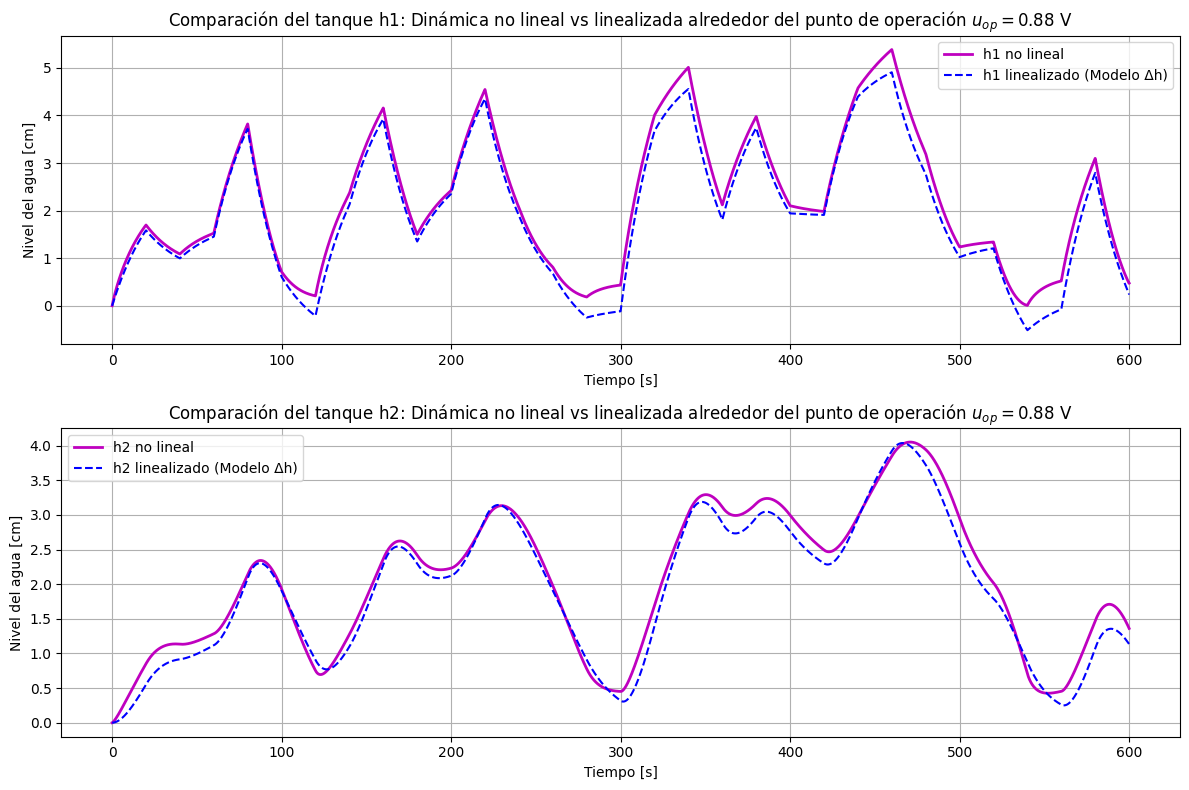

In [16]:
plt.figure(figsize=(12, 8))

# 1. Comparación de Alturas para el Tanque 1 (h1).
plt.subplot(2, 1, 1)
plt.plot(t_full, h1_full * 100, 'm', linewidth=2.0, label='h1 no lineal')
plt.plot(t_full, h1_lin * 100, 'b--', linewidth=1.5, label='h1 linealizado (Modelo Δh)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title(f'Comparación del tanque h1: Dinámica no lineal vs linealizada alrededor del punto de operación $u_{{op}}={u_op:.2f}$ V')
plt.legend()
plt.grid(True)

# 2. Comparación de Alturas para el Tanque 2 (h2).
plt.subplot(2, 1, 2)
plt.plot(t_full, h2_full * 100, 'm', linewidth=2.0, label='h2 no lineal')
plt.plot(t_full, h2_lin * 100, 'b--', linewidth=1.5, label='h2 linealizado (Modelo Δh)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nivel del agua [cm]')
plt.title(f'Comparación del tanque h2: Dinámica no lineal vs linealizada alrededor del punto de operación $u_{{op}}={u_op:.2f}$ V')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 📉 Análisis del Error de Aproximación

Este script calcula y visualiza el error de la linealización. El error es una métrica fundamental para determinar la fidelidad del modelo lineal obtenido con respecto al comportamiento real (no lineal) del sistema.

### Definición del Error

El error de aproximación $e_i(t)$ para cada tanque se define como la diferencia entre la respuesta del modelo no lineal ($h_{i, \text{full}}$, la referencia) y la respuesta del modelo linealizado ($h_{i, \text{lin}}$):

$$
e_i(t) = h_{i, \text{full}}(t) - h_{i, \text{lin}}(t)
$$


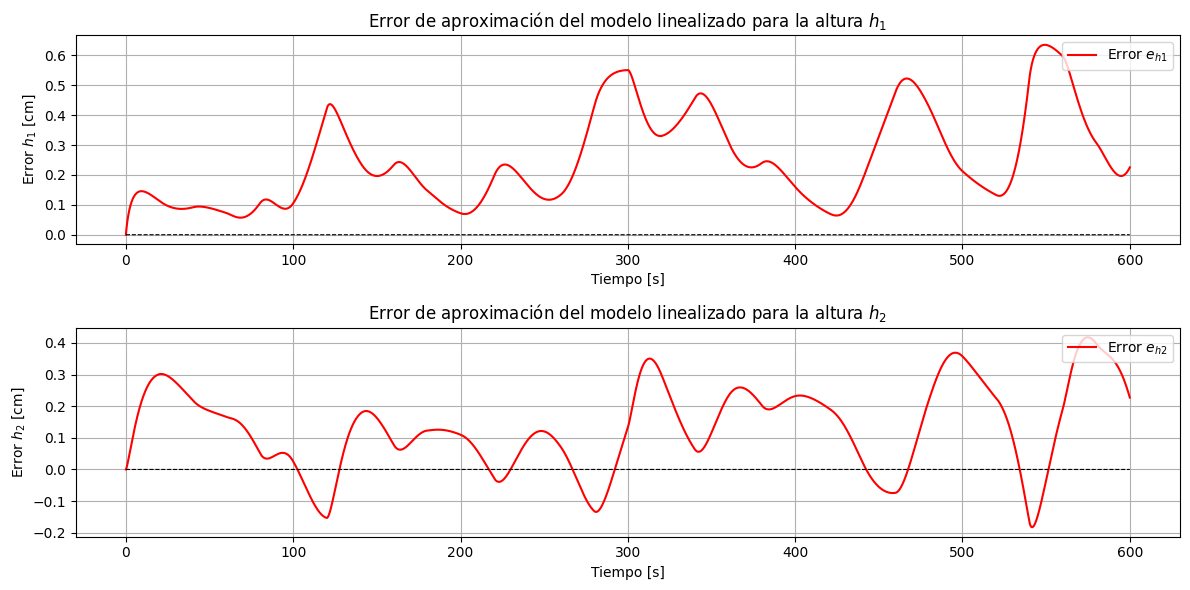

In [17]:
# Vector de error
error_h1 = h1_full - h1_lin
error_h2 = h2_full - h2_lin

# 2. Configuración de la figura para la visualización del error.
plt.figure(figsize=(12, 6))

# Subgráfica 1: Error en el nivel del Tanque 1 ($h_2$).
plt.subplot(2, 1, 1)
plt.plot(t_full, error_h1 * 100, 'r', linewidth=1.5, label='Error $e_{h1}$')
plt.plot(t_full, np.zeros_like(t_full), 'k--', linewidth=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Error $h_1$ [cm]')
plt.title(f'Error de aproximación del modelo linealizado para la altura $h_1$')
plt.legend(loc='upper right')
plt.grid(True)

# Subgráfica 2: Error en el nivel del Tanque 2 ($h_2$).
plt.subplot(2, 1, 2)
plt.plot(t_full, error_h2 * 100, 'r', linewidth=1.5, label='Error $e_{h2}$')
plt.plot(t_full, np.zeros_like(t_full), 'k--', linewidth=0.8)
plt.xlabel('Tiempo [s]')
plt.ylabel('Error $h_2$ [cm]')
plt.title(f'Error de aproximación del modelo linealizado para la altura $h_2$')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# 📊 Métricas de Evaluación de la Aproximación Lineal

El rendimiento de la aproximación lineal se cuantifica utilizando métricas de error estándar sobre el vector de error global $\mathbf{e}_{\text{full}}$.

### Métricas Globales (sobre $T_{\text{sim}}$)

Estas métricas evalúan la precisión del modelo linealizado durante toda la simulación.

| Métrica | Sigla | Fórmula | Unidad |
| :--- | :--- | :--- | :--- |
| **Error Cuadrático Medio** | **MSE** | $$\text{MSE} = \frac{1}{2N} \sum e^2$$ | $\text{m}^2$ |
| **Raíz del Error Cuadrático Medio** | **RMSE** | $$\text{RMSE} = \sqrt{\text{MSE}}$$ | $\text{m}$ |
| **Error Absoluto Medio** | **MAE** | $$\text{MAE} = \frac{1}{2N} \sum |e|$$ | $\text{m}$ |
| **Suma del Error Cuadrático** | **SSE** | $$\text{SSE}_{\text{Global}} = \sum e^2$$ | $\text{m}^2$ |
| **RMSE Normalizado** | **NRMSE** | $$\text{NRMSE} = \frac{\text{RMSE}}{\text{Rango}(\mathbf{h}_{\text{full}})}$$ | Adimensional |

In [18]:
# Concatenación de todos los errores
error_full = np.concatenate((error_h1, error_h2))

MSE = np.mean(error_full**2)
RMSE = np.sqrt(MSE)
MAE = np.mean(np.abs(error_full))
SSE = np.sum(error_full**2)

# Error cuadrático medio normalizado
h_full_concat = np.concatenate((h1_full, h2_full))
range_h = np.max(h_full_concat) - np.min(h_full_concat)

if range_h != 0:
    NRMSE = RMSE / range_h
else:
    NRMSE = 0.0

print("\n--------------------------- Métricas de Error de Aproximación -------------------------------")
print(f"MSE (Error Cuadrático Medio global)\t\t: {MSE:.8f} m^2 \t|({MSE*100:.8f} cm^2)")
print(f"RMSE (Raíz del Error Cuadrático Medio global)\t: {RMSE:.8f} m \t\t|({RMSE*100:.8f} cm)")
print(f"MAE (Error Absoluto Medio global)\t\t: {MAE:.8f} m \t\t|({MAE*100:.8f} cm)")
print(f"SSE (Suma del Error Cuadrático global)\t\t: {SSE:.8f} m^2 \t|({SSE*100:.8f} cm^2)")
print(f"NRMSE (Error Normalizado global)\t\t: {NRMSE:.8f} \t\t|(Adimensional)")


--------------------------- Métricas de Error de Aproximación -------------------------------
MSE (Error Cuadrático Medio global)		: 0.00000612 m^2 	|(0.00061180 cm^2)
RMSE (Raíz del Error Cuadrático Medio global)	: 0.00247346 m 		|(0.24734599 cm)
MAE (Error Absoluto Medio global)		: 0.00204910 m 		|(0.20491036 cm)
SSE (Suma del Error Cuadrático global)		: 0.14684433 m^2 	|(14.68443318 cm^2)
NRMSE (Error Normalizado global)		: 0.04593532 		|(Adimensional)


In [ ]:
# Error absoluto a almacenar
error_h1_cm = error_h1 * 100
error_h2_cm = error_h2 * 100

# Diccionario de columnas del CSV
datos_a_guardar = {
    'Tiempo_s': t_full,
    'Error_Abs_h1_lin_cm': error_h1_cm.flatten(),
    'Error_Abs_h2_lin_cm': error_h2_cm.flatten()
}

# Estructura de tabla
df_errores_lineal = pd.DataFrame(datos_a_guardar)

# Dataframe en formato CSV
nombre_archivo = 'errores_lineal.csv'
df_errores_lineal.to_csv(nombre_archivo, index=False)

print(f"\n✅ Errores del modelo LINEALIZADO guardados exitosamente en: {nombre_archivo}")
print("El archivo contiene las columnas: Tiempo_s, Error_Abs_h1_lin_cm, Error_Abs_h2_lin_cm.")


✅ Errores absolutos del modelo LINEALIZADO guardados exitosamente en: errores_absolutos_lineal.csv
El archivo contiene las columnas: Tiempo_s, Error_Abs_h1_lin_cm, Error_Abs_h2_lin_cm.
